## Check the GPU

In [1]:
!nvidia-smi

Sat Aug 31 13:28:43 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Import libraries

In [0]:
import numpy as np
import os
import time
import math
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(101)

# tensorflow imports
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.contrib.training import HParams

# tf.keras imports
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Add, Softmax, GlobalMaxPool2D
from tensorflow.keras.layers import BatchNormalization, MaxPool2D, Input, ReLU, Lambda
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
K.set_session(tf.Session(config=config))

# Image Augmenters
from albumentations import (Compose, HorizontalFlip, Cutout, PadIfNeeded, RandomCrop)

# One Cycle LR'
from clr import OneCycleLR, LRFinder

## Downloading Dataset

In [3]:
from tensorflow.keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 11s 0us/step


## View Data

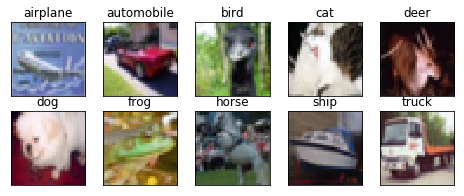

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

## Setting Hyperparams

In [0]:
hparams = HParams(
    learning_rate= 0.4,  # fixed learning rate
    batch_size= 512,  # training batch size
    momentum = 0.9, # fixed momentum
    n_epochs= 24,  # number of epochs to train
    decay = 1e-04 # learning rate*batch size
)

## Image Normalization and One hot encoding

In [0]:
#Image Normalization
train_features = train_features.astype('float32')
test_features = test_features.astype('float32')

mean = np.mean(train_features, axis=(0,1,2))
std = np.std(train_features, axis=(0,1,2))
X_train = (train_features - mean) / (std)
X_test = (test_features - mean) / (std)

# convert class labels to binary class labels
y_train = to_categorical(train_labels, num_classes)
y_test = to_categorical(test_labels, num_classes)

## Image Augmentation techniques

* Random Crop of 32x32 with padding of 4px
* Horizontal Flip
* CutOut of 8x8


In [0]:
# Custom Image augmentation 

def CustomImageDataGen(input_img):
    seq = Compose([PadIfNeeded(40,40, p=1),
                   RandomCrop(32,32, p=1),
                   HorizontalFlip(p=0.5),
                   Cutout(num_holes=1, p=0.5)
                  ], p=1)
    output_img = seq(image = input_img)['image']
    return output_img

datagen = ImageDataGenerator(preprocessing_function=CustomImageDataGen)
datagen.fit(X_train)

## Network Architecture (ResNet 9)

In [0]:
# PyTorch’s default way to set the initial, random weights of layers does not have 
# a counterpart in Tensorflow, so we borrow that

def init_pytorch(shape, dtype=tf.float32, partition_info=None):
    fan = np.prod(shape[:-1])
    bound = 1 / math.sqrt(fan)
    return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

In [0]:
# Linear layer to be used at end as prescribed by David
def linear_layer(x):
    return tf.math.multiply(x, 0.2)

In [0]:
def Resnet9(input_dim, n_classes):  
    inputs = Input(shape= input_dim, name='input')

    # Define the repeated conv_bn_relu function
    def conv_bn_relu(x, layer_name, pool=False):
        channels = {'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 256}
        conv_layer = Conv2D(filters = channels[layer_name], 
                            kernel_size = 3, 
                            strides = 1, 
                            padding = 'same',
                            kernel_initializer=init_pytorch,
                            kernel_regularizer=l2(hparams.decay),
                            use_bias=False)
        x = conv_layer(x)
        x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
        x = ReLU()(x)
        if pool==True:
            x = MaxPool2D(2)(x)
        return x        

    # Stack the layers
    # Layer Prep
    layer_prep = conv_bn_relu(inputs, 'prep')

    # Layer 1
    layer1_part1 = conv_bn_relu(layer_prep, 'layer1', pool=True)  
    layer1_part2_res1 = conv_bn_relu(layer1_part1, 'layer1')
    layer1_part2_res2 = conv_bn_relu(layer1_part2_res1, 'layer1')
    layer1 = Add()([layer1_part1, layer1_part2_res2])
    
    # Layer 2
    layer2_part1 = conv_bn_relu(layer1, 'layer2', pool=True)  
    layer2_part2_res1 = conv_bn_relu(layer2_part1, 'layer2')
    layer2_part2_res2 = conv_bn_relu(layer2_part2_res1, 'layer2')
    layer2 = Add()([layer2_part1, layer2_part2_res2])

    # Layer 3
    layer3 = conv_bn_relu(layer2, 'layer3', pool=True)

    # Layer Classifier
    layer_classifier = GlobalMaxPool2D()(layer3)
    layer_classifier = Flatten()(layer_classifier)
    layer_classifier = Dense(n_classes, kernel_initializer= init_pytorch,
                           kernel_regularizer=l2(hparams.decay),
                           use_bias=False, name='classifier')(layer_classifier)
    layer_classifier = Lambda(linear_layer)(layer_classifier)

    outputs = Softmax()(layer_classifier)

    model = Model(inputs, outputs)
    model.compile(loss='categorical_crossentropy',
                optimizer=SGD(lr= hparams.learning_rate, momentum= hparams.momentum, 
                              nesterov=True),
                metrics=['accuracy'])
    return model

In [11]:
# Model Summary
input_dim = X_train.shape[1:]
net = Resnet9(input_dim, num_classes)
net.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1728        input[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 32, 32, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Finding Max Learning rate for OneCycle LR

In [0]:
lr_callback = LRFinder(num_train, batch_size=512, lr_scale='exp', save_dir='.')
net.fit(X_train, y_train, epochs=1, batch_size=512, callbacks=[lr_callback])

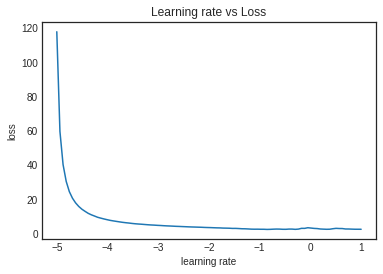

In [0]:
LRFinder.plot_schedule_from_file('.')

Its not clear from the graph, although we see a bump near 0.5. We will go with prescribed max lr of 0.4.

## Model Training 

In [12]:
# train the model
start = time.time()

#checkpointer
checkpointer = ModelCheckpoint(filepath="bestmodel.h5", verbose=0, 
                               save_best_only=True, monitor="val_acc")
# one cycle lr
lr_manager = OneCycleLR(max_lr= hparams.learning_rate, 
                        maximum_momentum=hparams.momentum, verbose=False)

# Fit the model
history = net.fit_generator(datagen.flow(X_train, y_train, 
                                         batch_size= hparams.batch_size, 
                                         shuffle=True), 
                            epochs = hparams.n_epochs, 
                            steps_per_epoch= np.ceil(X_train.shape[0]/hparams.batch_size),
                            validation_data=(X_test, y_test),
                            callbacks = [lr_manager, checkpointer])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

Epoch 1/24
98/98 [==============================] - 53s 544ms/step - loss: 1.4921 - acc: 0.4817 - val_loss: 1.1200 - val_acc: 0.6199
Epoch 2/24
98/98 [==============================] - 43s 435ms/step - loss: 0.8876 - acc: 0.7058 - val_loss: 1.1108 - val_acc: 0.6599
Epoch 3/24
98/98 [==============================] - 43s 434ms/step - loss: 0.6923 - acc: 0.7833 - val_loss: 0.9771 - val_acc: 0.7034
Epoch 4/24
98/98 [==============================] - 43s 435ms/step - loss: 0.6005 - acc: 0.8182 - val_loss: 0.8423 - val_acc: 0.7521
Epoch 5/24
98/98 [==============================] - 43s 435ms/step - loss: 0.5454 - acc: 0.8414 - val_loss: 0.5615 - val_acc: 0.8401
Epoch 6/24
98/98 [==============================] - 43s 435ms/step - loss: 0.5217 - acc: 0.8526 - val_loss: 0.8195 - val_acc: 0.7695
Epoch 7/24
98/98 [==============================] - 43s 435ms/step - loss: 0.4954 - acc: 0.8641 - val_loss: 0.6163 - val_acc: 0.8307
Epoch 8/24
98/98 [==============================] - 42s 433ms/step - 

## Model Evaluation

In [13]:
# load the model
from tensorflow.keras.models import load_model
bestmodel = load_model("bestmodel.h5", custom_objects={'init_pytorch': init_pytorch})

# Evaluation
score= net.evaluate(X_test, y_test, batch_size=hparams.batch_size, verbose=1)
print("Minimal Validation Loss : ", score[0])
print("Max Validation Accuracy:", score[1]*100, "%")

W0831 13:46:29.549999 140715470960512 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0831 13:46:29.554337 140715470960512 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


10000/10000 [==============================] - 2s 233us/sample - loss: 0.3712 - acc: 0.9347
Minimal Validation Loss :  0.3712153632640839
Max Validation Accuracy: 93.47000122070312 %


## Plot Loss and Accuracy History

In [0]:
def plot_model_history(history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # summarize history for accuracy
    axs[0].plot(range(1,len(history.history['acc'])+1),history.history['acc'])
    axs[0].plot(range(1,len(history.history['val_acc'])+1),history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(history.history['acc'])+1),len(history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    # summarize history for loss
    axs[1].plot(range(1,len(history.history['loss'])+1), history.history['loss'])
    axs[1].plot(range(1,len(history.history['val_loss'])+1), history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(history.history['loss'])+1),len(history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

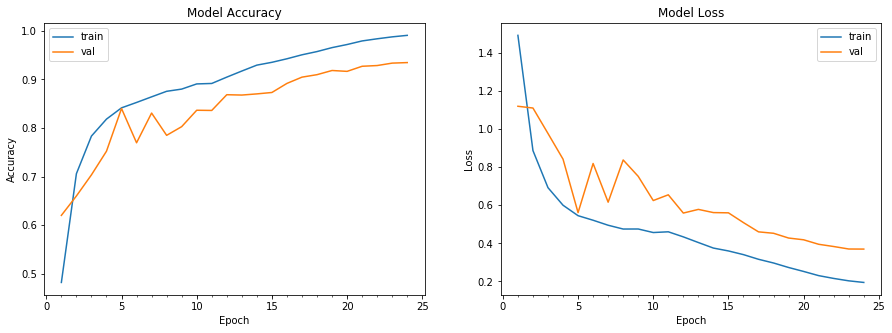

In [15]:
# plot model history
plot_model_history(history)

## Misclassified Images

In [16]:
#Prediction on validation dataset
valid_generator = ImageDataGenerator().flow(X_test, y_test, batch_size=hparams.batch_size,
                                            shuffle=False, seed=101)
pred_valid = net.predict_generator(valid_generator, steps= np.ceil(X_test.shape[0]/512), 
                                         verbose=0)
pred_labels = np.argmax(pred_valid, axis=1)
pred_labels[:10]

array([3, 8, 8, 0, 6, 6, 1, 6, 3, 1])

In [17]:
# True labels of validation dataset
true_labels = np.argmax(y_test,axis=1)
true_labels[:10]

array([3, 8, 8, 0, 6, 6, 1, 6, 3, 1])

In [23]:
# Generate the confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(true_labels, pred_labels))

[[940   8  14   5   4   2   2   0  16   9]
 [  6 972   1   0   0   0   0   0   5  16]
 [ 11   0 915  20  18  14  12   6   2   2]
 [  4   1  16 865  14  70  18   5   5   2]
 [  0   0  11  15 949  13   2  10   0   0]
 [  1   1  12  73  16 882   6   8   0   1]
 [  5   0  12  21   5   3 950   2   0   2]
 [  4   0   4   8   8  13   3 957   2   1]
 [ 18   3   4   2   0   0   0   1 964   8]
 [  8  24   1   4   0   0   0   0  10 953]]


In [19]:
# Total number of false predictions
mislabelled_index = []

for i in range(true_labels.shape[0]):
    if pred_labels[i] != true_labels[i]:
        mislabelled_index.append(i)

print('Number of False predictions: ', len(mislabelled_index),'out of', len(test_labels))

Number of False predictions:  653 out of 10000


## Grad CAM Visualization of any 25 misclassified images

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


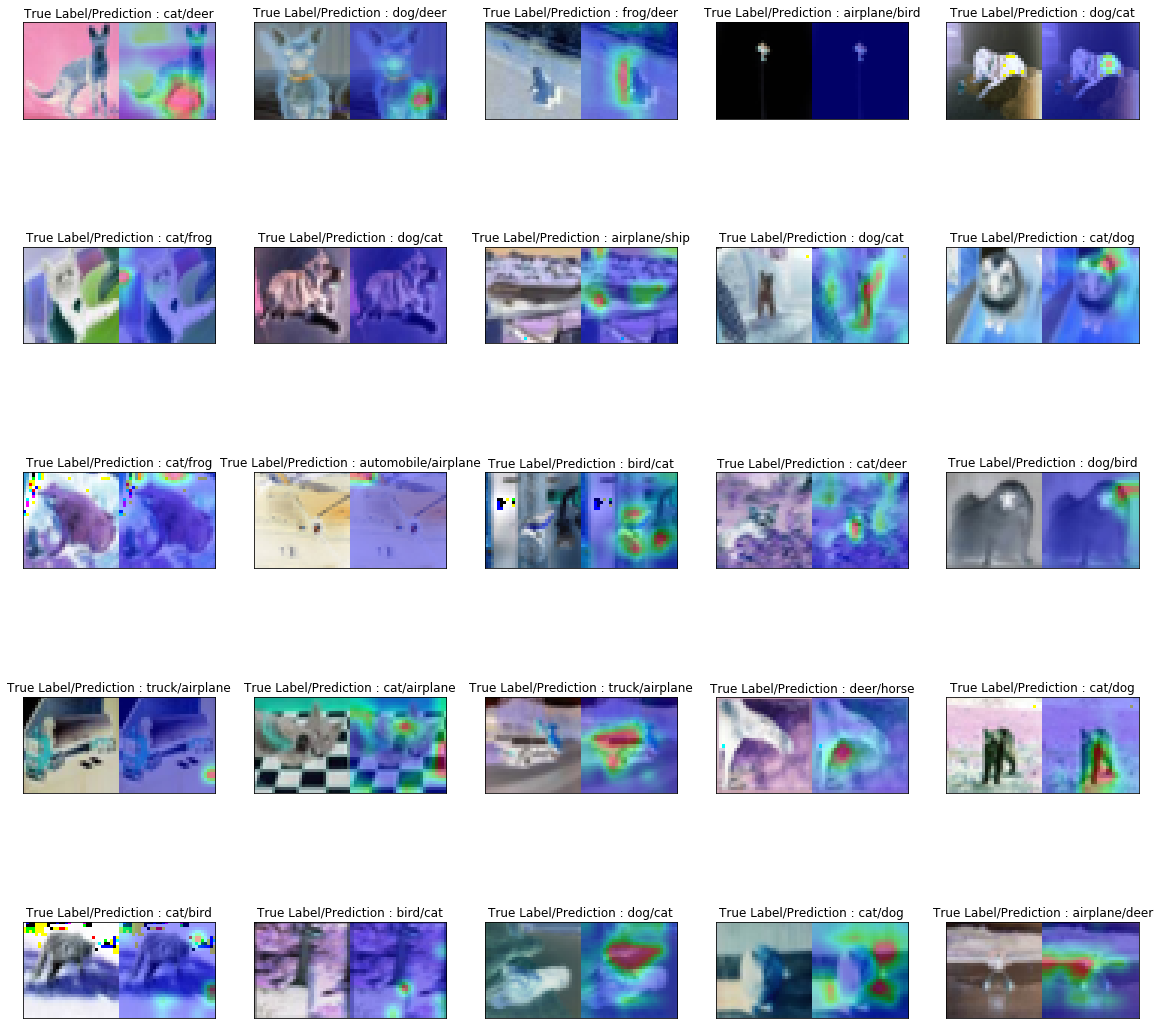

In [20]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.cm as cm 
figr = plt.figure(figsize=(20,20))

np.random.seed(0)
indices = np.random.choice(mislabelled_index, 25, replace=False)

for j in range(len(indices)):
    ax = figr.add_subplot(5, 5, 1 + j, xticks=[], yticks=[])
    x = test_features[indices[j]]
    x = np.expand_dims(x, axis=0)
    preds = bestmodel.predict(x)
    class_idx = np.argmax(preds[0])
    class_output = bestmodel.output[:, class_idx]
    last_conv_layer = bestmodel.get_layer("re_lu_7")

    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([bestmodel.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(256):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    img = np.uint8(255 * test_features[indices[j]])
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_RAINBOW)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    concat_img = cv2.hconcat([img, superimposed_img])
    ax.set_title("True Label/Prediction : {}/{}".format(class_names[true_labels[indices[j]]],
                                                        class_names[pred_labels[indices[j]]]))
    plt.imshow(concat_img)

plt.show()